In [73]:
import casadi as csd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.stats import chi2, f

In [74]:
# experimental conditions
expcond = [{'c0': [1.0, 2.0, 0.0, 0.0]}, {'c0': [1.0, 1.0, 0.0, 0.0]}]
meas_vars = [['ca', 'cb', 'cc'], ['ca', 'cc', 'cd']]
meas_vars_idx = [[0, 1, 2], [0, 2, 3]]
datasets = ['ABCD_data.csv', 'ABCD_data_2.csv']
expdata = []
for data in datasets:
    data_df = pd.read_csv(data)
    expdata.append(data_df)

In [75]:
# stoichiometry matrix for
# A + B -> C, B + C -> D
s = np.array([[-1.0, -1.0, 1.0, 0.0],
              [0.0, -1.0, -1.0, 1.0]
             ])

In [78]:
def rxnfn(kf, tf, s, tgrid = [-100]):
    
    nr, nc = s.shape
    
    c = csd.MX.sym('c', nc)
    
    r = []
    for i in range(nr):
        ri = kf[i]
        for j in range(nc):
            if s[i, j] < 0:
                ri = ri * c[j] ** (-s[i, j])
        r.append(ri) 
        
    dc = []
    for i in range(nc):
        dci = 0
        for j in range(nr):
            dci = dci + s[j, i] * r[j]
        dc.append(dci)
        
    ode = {}
    ode['x'] = c
    ode['p'] = kf
    ode['ode'] = csd.vertcat(*dc)
    
    if tgrid[0] == -100:
        F = csd.integrator('F','cvodes',ode,{'tf':tf})
    else:
        F = csd.integrator('F','cvodes',ode,{'tf':tf, 'grid': tgrid, 'output_t0' : True})
        
    return F

In [79]:
expinfo_list = [{'data': expdata[i], 'meas_var': meas_vars[i], 'meas_var_idx': meas_vars_idx[i], 'c0': expcond[i]['c0']}
                  for i in range(len(expdata))]

In [80]:
def get_exp_ssq(kf, expinfo):
    data = expinfo['data']
    meas_var = expinfo['meas_var']
    meas_var_idx = expinfo['meas_var_idx']
    c0 = expinfo['c0']
    tgrid = np.append(0, data['t'].values)
    ssq = 0
    for i in range(len(tgrid) - 1):
        F = rxnfn(kf = kf, tf = tgrid[i + 1] - tgrid[i], s = s)
        res = F(x0 = c0, p = kf)
        c0 = res['xf']
        for (j, var) in enumerate(meas_var):
            ssq = ssq + (data.iloc[i][var] - res['xf'][meas_var_idx[j]]) ** 2
    return ssq

In [81]:
def sim_exp(kf, expinfo, tf):
    data = expinfo['data']
    meas_var = expinfo['meas_var']
    meas_var_idx = expinfo['meas_var_idx']
    c0 = expinfo['c0']
    tgrid = list(np.linspace(0, tf))
    F = rxnfn(kf = kf, tf = tf, s = s, tgrid = tgrid)
    res = F(x0 = c0, p = kf)
    res_fn = csd.Function('res_fn', [kf], [res['xf']])
    return res_fn

In [82]:
kf = csd.MX.sym('kf', 2)
exp_ssq = 0
for i in range(len(expdata)):
    exp_ssq = exp_ssq + get_exp_ssq(kf, expinfo_list[0])

In [83]:
exp_ssq_fn = csd.Function('exp_ssq_fn', [kf], [exp_ssq])

In [84]:
# function to calcuate hessian of sum of squares with respect to p = (k1, k2)
ssqfn_hess_calc = csd.hessian(exp_ssq_fn(kf), kf)
ssqfn_hess = csd.Function('ssqfn_hess', [kf], [ssqfn_hess_calc[0]])

In [85]:
# NLP declaration
nlp = {'x': kf,'f': exp_ssq};

# Solve using IPOPT
solver = csd.nlpsol('solver','ipopt',nlp)
res = solver(x0=[3, 3], lbx = 0, ubx = 10)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [86]:
p_est = res['x']
p_est

DM([0.949272, 0.212212])

In [89]:
res_fn = sim_exp(kf, expinfo_list[1], tf = 10)
cf = res_fn(p_est).full().T

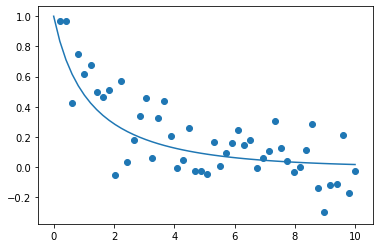

In [90]:
t = list(np.linspace(0, 10))
datum = expinfo_list[1]['data']
fig, ax = plt.subplots()
ax.plot(t, cf[:, 1])
ax.scatter(datum['t'], datum['cb'])

In [100]:
## calculate covariance matrix

# number of estiamted parameters
n_est = 2
# number of data points
n_data = np.sum([expdata[i].shape[0] * len(meas_vars[i]) for i in range(len(expdata))])


# hessian
H_sol = ssqfn_hess(p_est)
# mean sum of squares
msq = res['f'] / (n_data - n_est)
print("mean sum of squares", msq)

print("Covariance matrix")
cov = 2 * msq * linalg.inv(H_sol)
print(cov)

mean sum of squares 0.0425931
Covariance matrix

[[0.00808611, -0.000135221], 
 [-0.000135221, 0.000212259]]
